# Model Prototype

### This notebook shows how to create a baseline model pipeline and save it

##### We save the Spark Dataframe as an Iceberg Table. Iceberg is a new open table format backed by Apple, Netflix and Cloudera. 
##### In the context of ML Ops, the most anticipated feature is Time Travel i.e. the ability to reproduce the data and the schema across different versions in time
##### Finally, we create a simple PySpark pipeline and train a classifier with Keras/Tensorflow

* For a more comprehensive demo of Iceberg in CML, please visit the [Spark3 Iceberg CML Github Repository](https://github.com/pdefusco/Spark3_Iceberg_CML)
* For a more detailed introduction to CML Session, Notebooks, and Spark tips and trips please visit the [CML Total Beginner GitHub Repository](https://github.com/pdefusco/CML-Total-Beginner)
* For a more comprehensive example of the Atlas Python client mentioned below, please visit the [Atlas Client Example Notebook in the Data Integration with ML GitHub Repository](https://github.com/pdefusco/Data_Integration_wMachineLearning/blob/main/2_A_Atlas_Client_Example.ipynb)

In [1]:
#spark.stop()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from sklearn.datasets import make_circles
import tensorflow as tf
import pandas as pd
import seaborn as sns
from utils.plot_decision_boundary import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### The Spark Session is created with the following configurations. If you get an error, ensure your CML Session is using Runtimes and Spark 3.1.

In [3]:
spark = SparkSession.builder.master('local[*]')\
  .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\
  .config("spark.yarn.access.hadoopFileSystems","s3a://demo-aws-go02/")\
  .config("spark.executor.memory","2g")\
  .config("spark.executor.instances","2")\
  .config("spark.executor.cores","2")\
  .config("spark.driver.memory","2g")\
  .config("spark.jars.packages","org.apache.iceberg:iceberg-spark3-runtime:0.12.1")\
  .config("spark.sql.extensions","org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")\
  .config("spark.sql.catalog.spark_catalog","org.apache.iceberg.spark.SparkSessionCatalog")\
  .config("spark.sql.catalog.spark_catalog.type","hive")\
  .getOrCreate()

#### Loading the data...

In [4]:
# Load and parse the data file, converting it to a DataFrame.
df = spark.read.csv('data/LoanStats_2015_subset_120321.csv',   
    header=True,
    sep=',',
    nullValue='NA')

#### Investigating Target Class Imbalance

In [5]:
df.select("loan_status").distinct().show()

+------------------+
|       loan_status|
+------------------+
|        Fully Paid|
|           Default|
|   In Grace Period|
|       Charged Off|
|Late (31-120 days)|
|           Current|
|             10500|
| Late (16-30 days)|
+------------------+



In [6]:
#Types of loan status
print(df.groupBy('loan_status').count().show())

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid|55312|
|           Default|    4|
|   In Grace Period| 1116|
|       Charged Off|19719|
|Late (31-120 days)| 2080|
|           Current|66675|
|             10500|    1|
| Late (16-30 days)|  425|
+------------------+-----+

None


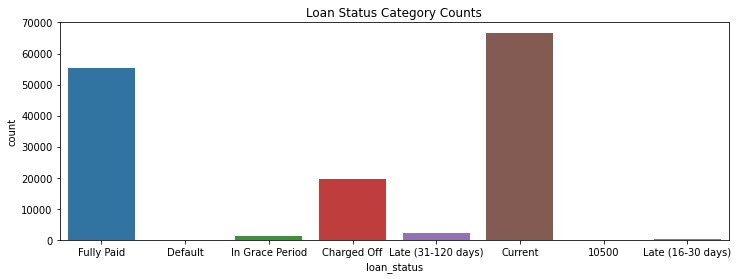

In [7]:
df_plot = df.groupBy('loan_status').count().toPandas()
plt.figure(figsize=(12,4))
g = sns.barplot(x="loan_status", y="count", data=df_plot)
g.set_title('Loan Status Category Counts')
plt.show()

We want to predict Default vs Non-Default Loan Applicants...

#### Creating the Target Feature

In [8]:
df = df.withColumn("label", when((df["loan_status"] == "Charged Off")|(df["loan_status"] == "Default"), 1).otherwise(0))

We start with a baseline...  we decide to start with only a few key features.

In [9]:
df = df.select(['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt', 'label'])
df = df.dropna()

#### Let's create a simple Baseline Model Pipeline

In [10]:
train = df.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=10)

In [11]:
test = df.subtract(train)

In [12]:
train.dtypes

[('acc_now_delinq', 'string'),
 ('acc_open_past_24mths', 'string'),
 ('annual_inc', 'string'),
 ('avg_cur_bal', 'string'),
 ('funded_amnt', 'string'),
 ('label', 'int')]

In [13]:
import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [14]:
from handyspark import *

In [15]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df):        
     
    for c in spark_df.columns:
        spark_df = spark_df.withColumn(c, spark_df[c].cast("float"))
    
    stages= []

    cols = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt']
    
    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=cols, outputCol="features").setHandleInvalid("skip")
    stages += [assembler]    
    
    #Scaling features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    stages += [scaler]
    
    #Logistic Regression
    lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label', maxIter=100, regParam=0.0001, elasticNetParam=0.0001)
    stages += [lr]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)

    return pipelineModel

In [16]:
pipelineModel = make_pipeline(train)

In [17]:
def cols_to_float(df):
    for c in df.columns:
        df = df.withColumn(c, df[c].cast("float"))
    return df

In [18]:
test = cols_to_float(test)
clf_out_df = pipelineModel.transform(test)

In [19]:
clf_out_df.select("label", "prediction").groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|29169|
|       1.0|   38|
+----------+-----+



In [20]:
clf_out_df.select("label", "prediction").groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0| 3882|
|  0.0|25325|
+-----+-----+



In [21]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(clf_out_df, scoreCol='probability', labelCol='label')

/home/cdsw/.local/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


/home/cdsw/.local/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


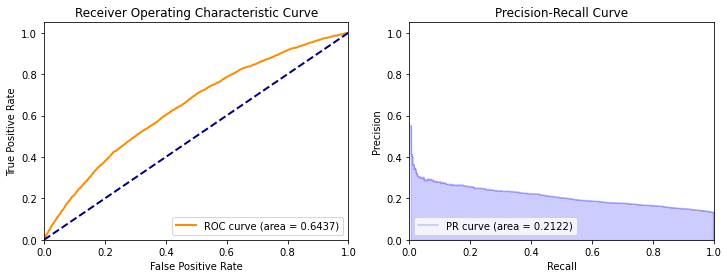

In [22]:
# Now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
plt.show()

In [23]:
def get_confusion_matrix(spark_df):

    input_data = spark_df.rdd.map(lambda x: (x["label"], x["prediction"], float(x["probability"][1])))
    predictions = spark.createDataFrame(input_data, ["label", "prediction", "probability"])

    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()

    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_true, y_pred))
    cf_matrix = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
    
    import seaborn as sns
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')


              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93     25325
         1.0       0.47      0.00      0.01      3882

    accuracy                           0.87     29207
   macro avg       0.67      0.50      0.47     29207
weighted avg       0.82      0.87      0.81     29207



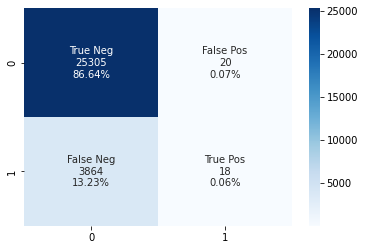

In [24]:
get_confusion_matrix(clf_out_df)

#### Time to train the classifier on the original data and deploy our scoring pipeline with CML Jobs

In [25]:
def score_data(df):
    
    #Scoring on the entire dataset now
    df = cols_to_float(df)
    pipelineModel = make_pipeline(df)
    scored_df = pipelineModel.transform(df)
    scored_df = scored_df.select("acc_now_delinq", "acc_open_past_24mths", "annual_inc", "avg_cur_bal", "funded_amnt", "label")

    return scored_df, pipelineModel

In [26]:
scored_df, pipelineModel = score_data(df)

In [27]:
#This is a sample of what we will save to the datawarehouse
scored_df.show(4)

+--------------+--------------------+----------+-----------+-----------+-----+
|acc_now_delinq|acc_open_past_24mths|annual_inc|avg_cur_bal|funded_amnt|label|
+--------------+--------------------+----------+-----------+-----------+-----+
|           0.0|                 8.0|   65000.0|    10086.0|    12000.0|  0.0|
|           0.0|                 1.0|  150000.0|    61551.0|    25000.0|  0.0|
|           0.0|                 8.0|   75000.0|     7176.0|    28000.0|  0.0|
|           0.0|                 7.0|  175000.0|    51015.0|    30000.0|  0.0|
+--------------+--------------------+----------+-----------+-----------+-----+
only showing top 4 rows



#### We will store the classifier locally but we could also use other storage options (S3, ADLS, GCS, HDFS, Ozone, etc.)

In [28]:
def save_local_clf(clf_pipeline):
    clf_pipeline.write().save("/home/cdsw/models")

def save_s3_clf(clf_pipeline):
    #Saving pipeline to S3:
    clf_pipeline.write().save("s3a://demo-aws-go02/datalake/pdefusco/pipeline")

In [32]:
#save_local_clf(pipelineModel)
#pipelineModel.write().overwrite().save("s3a://demo-aws-go02/datalake/pdefusco/pipeline")

with open('model_pkl', 'wb') as files:
    pickle.dump(model, files)

TypeError: can't pickle _thread.RLock objects

### We can save the Scored Dataset into an Iceberg Table

### Notice that we retrained the model on the original dataset with the actual label. But we will create a new table replacing the label with the prediction. That is because our goal will be to score the model with fresh data, when it becomes available.

#### For the time being we will store the original labels in the prediction column. 

In [ ]:
# Saving the Spark Dataframe as an Iceberg table
spark.sql("CREATE TABLE IF NOT EXISTS ice_cml (acc_now_delinq float, acc_open_past_24mths float, annual_inc float, avg_cur_bal float, funded_amnt float, prediction int) USING iceberg")

In [ ]:
scored_df = scored_df.withColumnRenamed('label', 'prediction')

In [ ]:
scored_df.write.format("iceberg").mode("overwrite").save("default.ice_cml")

#### The table is automatically tracked by the Data Lake associated with the CML Workspace

#### To check that a new entry for the table has been added to Atlas in the Data Lake, go back to the CDP Homepage and open Data Catalog. 

#### Select the Data Lake (i.e. Cloud Environment) that your worskpace was built in. 

![title](images/select-datacatalog.png)

#### Use the Atlas Search bar at the top to browse for the table and click on it

![title](images/cml-table-meta.png)

#### Notice Atlas is tracking a lot of interesting Metadata including Table Attributes, Lineage, and a lot More. 

![title](images/cml-table-inatlas.png)

![title](images/cml-table-lineage.png)

### The above lineage graph only shows data. CML allows you to track data and ML models in a single graph. This is done via a yml file. We will see how that works in the next Notebooks. 

#### Finally, Atlas Metadata can be customized. For example, you could add custom entities to its entity model in order to ML specific transformations such as intermediate steps in a pipeline, or even custom methods. 
#### [This notebook](https://github.com/pdefusco/Data_Integration_wMachineLearning/blob/main/2_A_Atlas_Client_Example.ipynb) shows how you can use the Atlas Python Client to build custom lineage flows.

#### We are done with our Model Baseline. Next, launch the CICD.ipynb notebook to deploy this pipeline as CML Jobs using the CML API V2.